# Autoencoder
In this notebook, we are going to be focusing on the basic autoencoder trainer in autoencoder module in PAI-Utils.

## Setup
First, we will need to import packages and get the Cifar10 dataset.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image, display

from paiutils import image
from paiutils import neural_network as nn
from paiutils import autoencoder as ae

# see if using GPU and if so enable memory growth
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Get Cifar10 Dataset
1. Download the Cifar10 dataset
2. Scale the images and discard the labels
3. Batch the datasets and create a dictionary of the data

In [2]:
# Get dataset
cifar = tfds.image_classification.Cifar10()
cifar.download_and_prepare()
print(cifar.info.features)
print(cifar.info.splits)
data = cifar.as_dataset()
num_train_examples = cifar.info.splits['train'].num_examples

# Preprocess dataset
def preprocess(x):
    img = x['image']
    img = tf.cast(img, tf.float32) / 255.0
    return img, img
train_data = data['train'].map(preprocess)
val_data = data['test'].map(preprocess)
print(train_data)

# Batch the dataset and make dictionary
batch_size = 16
data = {'train': train_data.repeat().batch(batch_size),
        'validation': val_data.batch(batch_size)}
input_shape = train_data.element_spec[0].shape
output_shape = train_data.element_spec[1].shape

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
{'test': <tfds.core.SplitInfo num_examples=10000>, 'train': <tfds.core.SplitInfo num_examples=50000>}
<MapDataset shapes: ((32, 32, 3), (32, 32, 3)), types: (tf.float32, tf.float32)>


## Create the Model
We will now make an encoder model for encoding the image and a decoder model for decoding the encoding. We do not actually have to make the full autoencoder model as the autoencoder trainer will combine the models for us.

In [3]:
x0 = keras.layers.Input(shape=input_shape)
x = nn.conv2d(64, 3, 2)(x0)
x = nn.conv2d(128, 3, 2)(x)
x = nn.conv2d(256, 3, 2)(x)
x = nn.conv2d(512, 3, 2)(x)
x = keras.layers.Flatten()(x)
output = nn.dense(64)(x)
encoder_model = keras.Model(inputs=x0, outputs=output)
encoder_model.compile(optimizer='adam', loss='mse')
encoder_model.summary()

x0 = keras.layers.Input(shape=(64,))
x = nn.dense(2048)(x0)
x = keras.layers.Reshape((2, 2, 512))(x)
x = nn.conv2d(512, 3, 2, transpose=True)(x)
x = nn.conv2d(256, 3, 2, transpose=True)(x)
x = nn.conv2d(128, 3, 2, transpose=True)(x)
x = nn.conv2d(64, 3, 2, transpose=True)(x)
output = nn.conv2d(3, 1, 1, activation='sigmoid', batch_norm=False)(x)
decoder_model = keras.Model(inputs=x0, outputs=output)
decoder_model.compile(optimizer='adam', loss='mae')
decoder_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        1728      
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         73728     
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         294912    
_________________________________________________________________
batch_normalization_12 (Batc (None, 4, 4, 256)        

## Train the Model
We can now use the AutoencoderTrainer to train the encoder and decoder models on the Cifar10 dataset.

In [4]:
steps_per_epoch = int(len(train_data) // batch_size)
trainer = ae.AutoencoderTrainer(encoder_model, decoder_model, data)
trainer.train(10, steps_per_epoch=steps_per_epoch)
path = trainer.save('')
trainer.eval(steps=100)

Epoch 1/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.1020 - val_loss: 0.2131
Epoch 2/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.0864 - val_loss: 0.1369
Epoch 3/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.0826 - val_loss: 0.1010
Epoch 4/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.0801 - val_loss: 0.0857
Epoch 5/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.0779 - val_loss: 0.0806
Epoch 6/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.0766 - val_loss: 0.0812
Epoch 7/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.0756 - val_loss: 0.0772
Epoch 8/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.0748 - val_loss: 0.0769
Epoch 9/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.0739 - val_loss: 0.0741
Epoch 10/10
3125/3125 [==============================] - 26s 8ms/step - l

{'Train': 0.07024229317903519, 'Validation': 0.07122593373060226}

## Test the Model
We will test the model by using the AutoencoderPredictor to load the saved model and weights

In [5]:
# path = 'trained_model1'
predictor = ae.AutoencoderPredictor(path)

model
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_7 (Functional)    (None, 64)                1685184   
_________________________________________________________________
functional_9 (Functional)    (None, 32, 32, 3)         4050883   
Total params: 5,736,067
Trainable params: 5,728,003
Non-trainable params: 8,064
_________________________________________________________________

encoder_model
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        1728   

We will display the input images on the left and the predicted images on the right.

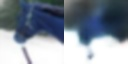

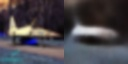

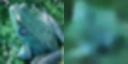

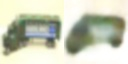

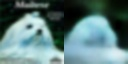

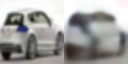

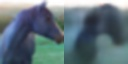

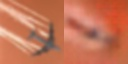

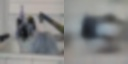

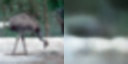

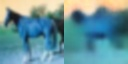

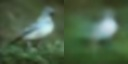

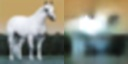

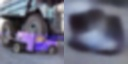

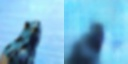

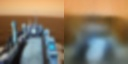

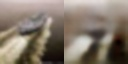

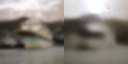

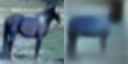

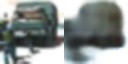

In [6]:
%matplotlib inline
example_data = val_data.take(20)
for example in example_data:
    x =  example[0].numpy()
    
    pred = predictor.predict(x)
    pred = pred * 255.0
    
    x = x * 255.0
    ret = image.cv2.imencode('.jpg', np.hstack([image.pyr(x, 1), image.pyr(pred, 1)]))[1]
    display(Image(data=ret))

The model does not perform perfectly, but with a compression rate of 48x, it's somewhat impressive.